# Analyse du fonctionnement d'une sous-station

Maintenant que la modélisation d'une sous-station n'a plus de secret pour vous, nous vous proposons d'analyser le fonctionnement de la sous-station modélisée. Pour cela, le code que vous avez élaboré au précédent notebook a été converti en deux fonctions distinctes :
- une fonction nommée **"SST_nom"** qui permet de déterminer les <ins>caractéristiques nominales</ins> de la sous-station lors de sa création comme objet Python
- une fonction nommée **"SST_fonct"** qui permet de calculer un point de fonctionnement de la sous-station en <ins>conditions non-nominales</ins>:

Une évolution a toutefois été apportée en matière de régulation de la sous-station. Afin d'améliorer dynamique de la régulation, le calcul est réalisé à un pas de temps de deux minutes au lieu des dix minutes initialement.

De plus, on ajoute un terme intégrateur à la boucle de régulation, ce qui permet de réduire l'écart statique de régulation. Le régulateur devient donc un régulateur proportionnel-intégral (PI) dont les paramètres vous seront fournis par la suite. La commande de régulation est donné par l'équation suivante (le terme dérivé est nul dans notre cas):


<div style="width:600px;margin:auto; margin:auto;">
<center>

![alt text](<Images/equ régulation PID.jpg>)
<center/>
</div> 

Ces fonctions sont écrites dans le fichier `ComposantsRDC.py` présent dans le dossier `\\Models`.
Vous découvrirez ci-dessous la nouvelle synthaxe du code.

Dans un second temps, il vous est proposé d'utiliser ce code pour analyser le fonctionnement de la sous-station pour différents paramétrages du modèle

# Présentation du code pour la modélisation d'une sous-station

*Prenez simplement connaissance du code et constatez que le résultat est identique au notebook précédent*

**Importation des bibliothèques**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dossier = os.getcwd()
os.chdir(dossier+'\\Models')
import ComposantsRDC as RDC
os.chdir(dossier)

**Données d'entrées**

In [2]:
#Chargement des données d'entrée
os.chdir(dossier+'\\Inputs')
Input = pd.read_excel('Entree_SST_Test.xlsx') #lecture des données d'entrées dans le fichier Excel
temps_simu = len(Input) #nombre de pas de temps
os.chdir(dossier)

Tp_in = 60*np.ones(temps_simu)
Text = np.array(Input['Text']) # Vecteur des températures extérieures
P_SST = np.array(Input['P (W)']) # Vecteur des puissances appelées côté secondaire

**Définition du point nominal**

Rappel: la sous-station a une puissance nominale de 20 kW, une efficacité de 0,9. Elle alimente un réseau secondaire fonctionnant sur un régime nominal de température 80/60°C.

Afin de vous rendre compte des améliorations portées à la régulation, nous vous proposons d'observer successivement les résultats pour les 3 configurations suivantes:

1. situation initiale : Kp= 0.01, Ki= 0, dt = 1 (Kd=0)
2. discrétisation temporelle du calcul : Kp= 0.01, Ki= 0, dt = 0.2 (Kd=0)
3. ajout du terme intégrateur : Kp= 0.01, Ki= 0.05, dt = 0.2 (Kd=0)

In [3]:
#Caractéristiques nominales connues de la SST
P_nom = 20000
E_nom = 0.9
Ts_in_nom = 60
Ts_out_nom = 80

#Paramètres de la régulation
Kp = 0.01 #terme proportionnel
Ki = 0.05  #terme intégrateur
Kd = 0.0   #terme dérivateur
dt = 0.2 #échantillonnage temporel de la régulation (ie discrétisation temporelle de la simulation de la régulation)

#Détermination du point nominal
Carac_nom=RDC.SST_nom(Kp, Ki, Kd, Ts_out_nom, Ts_in_nom, E_nom, P_nom)

**Initialisation du calcul**

In [4]:
SST_State = np.zeros((int(temps_simu/dt),9)) #Vecteur des sorties calculées (P_fournie, Tcons, Ts_out, Tp_out, Mp, Ts_in, EcartT, IntegraleEcartT, Youv)
SST_State[0,8] = 0.5  #Initialisation de l'ouverture de la vanne
SST_State[0,6] = 0 #Initialisation de l'écart à la consigne
SST_State[0,7] = 0 #Initialisation de la dérivée de l'écart


Tp_in_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Tp_in)
P_SST_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),P_SST)
Text_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Text)


**Boucle de calcul**

In [5]:
for t in range(1,int(temps_simu/dt)):
    SST_State[t]=RDC.SST_fonct(Carac_nom, SST_State[t-1,8], Tp_in_discret[t], P_SST_discret[t], Text_discret[t], SST_State[t-1,6], SST_State[t-1,7], dt)

**Sortie graphique**

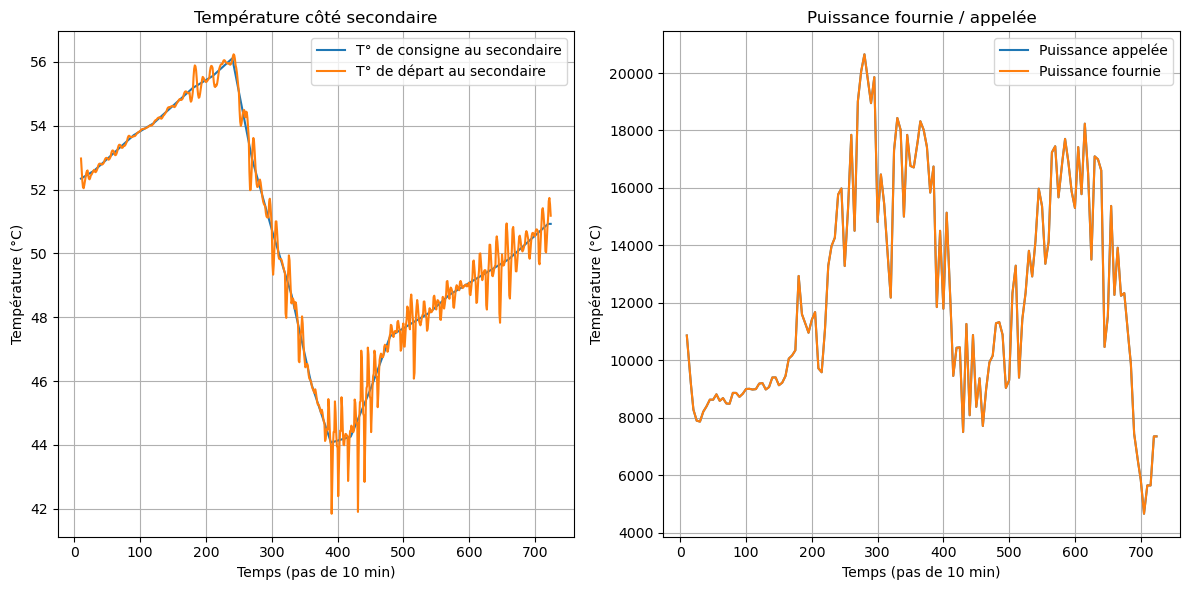

In [6]:
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0, ax1 = axes.flatten()

ax0.plot(np.arange(10,int(temps_simu/dt)),SST_State[10:,1], label = "T° de consigne au secondaire")
ax0.plot(np.arange(10,int(temps_simu/dt)),SST_State[10:,2], label = "T° de départ au secondaire")
ax0.set_title('Température côté secondaire')
ax0.legend()
ax0.grid()
ax0.set_xlabel('Temps (pas de 10 min)')
ax0.set_ylabel('Température (°C)')

ax1.plot(np.arange(10,int(temps_simu/dt)),P_SST_discret[10:], label = "Puissance appelée")
ax1.plot(np.arange(10,int(temps_simu/dt)),SST_State[10:,0], label = "Puissance fournie")
ax1.set_title('Puissance fournie / appelée')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Temps (pas de 10 min)')
ax1.set_ylabel('Température (°C)')

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'

# Etude paramétrique de la sous-station

Dans cette partie, on analyse le fonctionnement de la sous-station dans les cas de figures suivants :
- Surdimensionnement de l’échangeur 
- Sous-dimensionnement de l’échangeur 
- Changement de régime au secondaire 
- Diminution de l’efficacité

L’analyse du fonctionnement de la sous-station reposera sur l’observation des principales sorties des modèles : températures de sortie côté primaire et secondaire, débit côté primaire, ouverture de la vanne de régulation.
Vous pourrez ainsi conclure quant à la performance relative des différentes configurations testées par rapport la configuration initiale (« référence »).

Pour cette étude paramétrique, on va simuler le fonctionnement de la sous-station sur plusieurs jours. On utilisera donc le fichier d'entrée nommé `Entree_SST_Parametrique.xlsx`

**Les résultats sous forme de graphique sont automatiquement enregistrés dans le dossier \\Résultats**


In [7]:
#Chargement des données d'entrée
os.chdir(dossier+'\\Inputs')
Input = pd.read_excel('Entree_SST_Parametrique.xlsx') #lecture des données d'entrées dans le fichier Excel
temps_simu = len(Input) #nombre de pas de temps
os.chdir(dossier)
Tp_in = 60*np.ones(temps_simu)
Text = np.array(Input['Text']) # Vecteur des températures extérieures
P_SST = np.array(Input['P (W)']) # Vecteur des puissances appelées côté secondaire

## Configuration de référence

On étudie une sous-station de puissance nominale de 100 kW, d'efficacité 0.9 qui alimente un réseau secondaire fonctionnant sur le régime 80/60°C.  Le régulateur a un gain proportionnel de 0,005 et intégral de 0,05 (le gain dérivé est nul).

In [8]:
#Caractéristiques nominales connues de la SST
P_nom = 100000
E_nom = 0.9
Ts_in_nom = 60
Ts_out_nom = 80

#Paramètres de la régulation
Kp = 0.005 #terme proportionnel
Ki = 0.05  #terme intégrateur
Kd = 0.0   #terme dérivateur
dt = 0.2 #échantillonnage temporel de la régulation (ie discrétisation temporelle de la simulation de la régulation)

#Détermination du point nominal
Carac_nom=RDC.SST_nom(Kp, Ki, Kd, Ts_out_nom, Ts_in_nom, E_nom, P_nom)

In [9]:
#Initialisation
SST_State = np.zeros((int(temps_simu/dt),9)) #Vecteur des sorties calculées (P_fournie, Tcons, Ts_out, Tp_out, Mp, Ts_in, EcartT, IntegraleEcartT, Youv)
SST_State[0,6] = 0 #Initialisation de l'écart à la consigne
SST_State[0,7] = 0 #Initialisation de la dérivée de l'écart
SST_State[0,8] = 0.5  #Initialisation de l'ouverture de la vanne

Tp_in_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Tp_in)
P_SST_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),P_SST)
Text_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Text)

#Boucle de calcul
for t in range(1,int(temps_simu/dt)):
    SST_State[t]=RDC.SST_fonct(Carac_nom, SST_State[t-1,8], Tp_in_discret[t], P_SST_discret[t], Text_discret[t], SST_State[t-1,6], SST_State[t-1,7], dt)
SST_reference=SST_State

print("L'écart moyen et l'écart quadratique moyen sont respectivement de ", np.round(np.mean(SST_State[:,6]),3)," et de ", np.round(np.sqrt(np.mean(np.square(SST_State[:,6]))),3),".")


L'écart moyen et l'écart quadratique moyen sont respectivement de  1.254  et de  3.097 .


**Sorties graphiques**

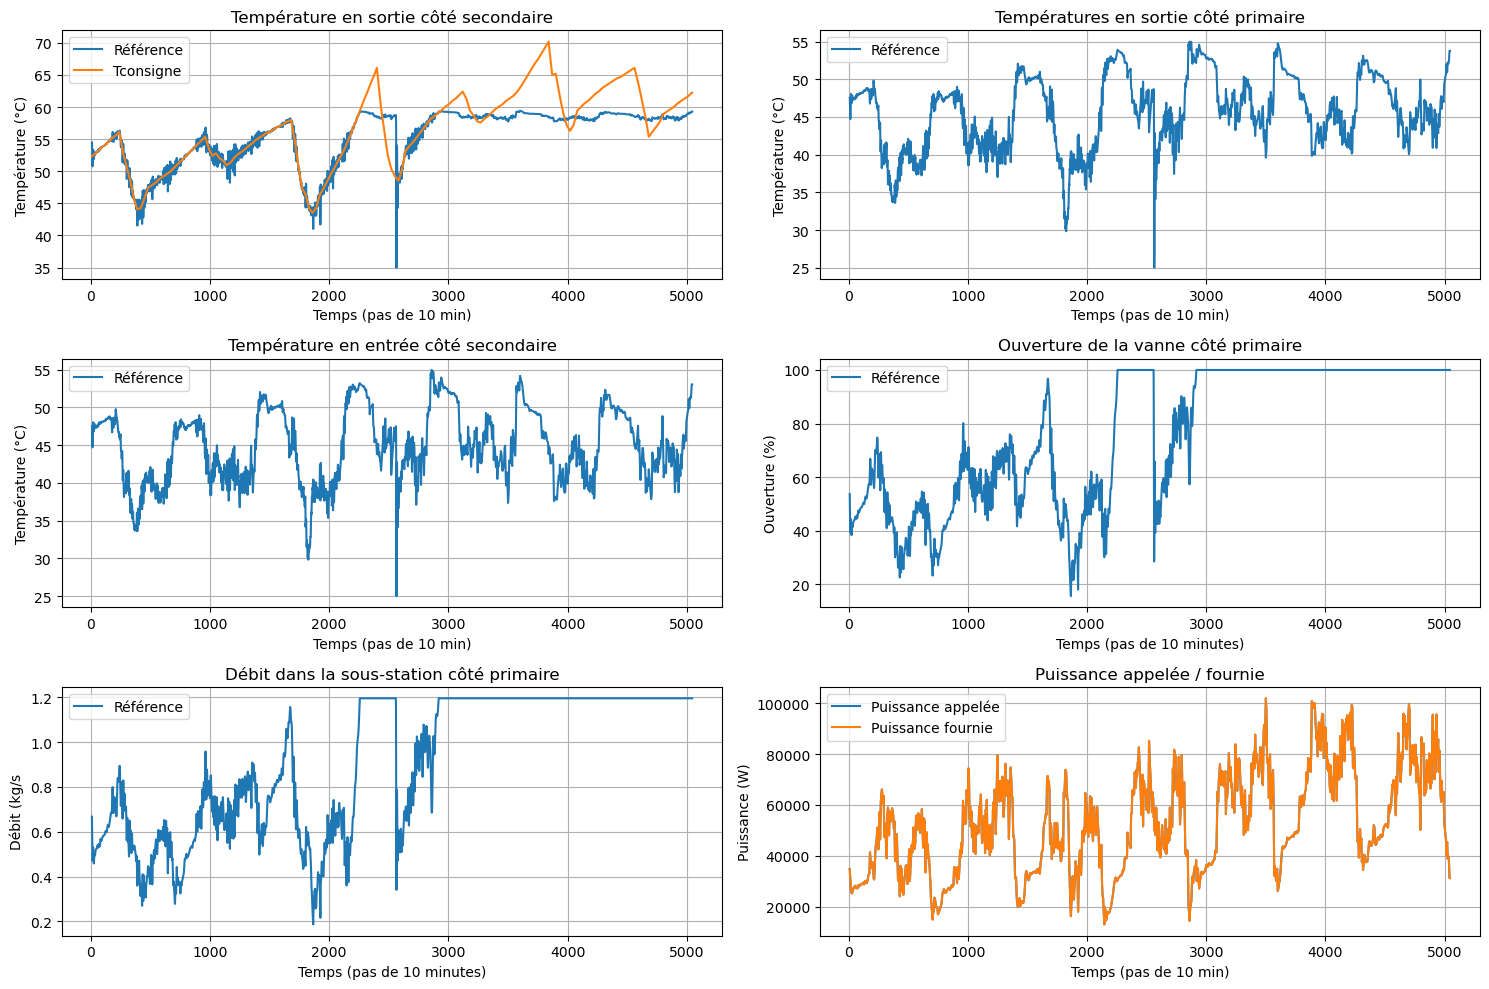

In [10]:
fig1, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,2], label = "Référence")
ax0.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,1], label = "Tconsigne")
ax0.set_title('Température en sortie côté secondaire')
ax0.legend()
ax0.grid()
ax0.set_xlabel('Temps (pas de 10 min)')
ax0.set_ylabel('Température (°C)')

ax1.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,3], label = "Référence")
ax1.set_title('Températures en sortie côté primaire')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Temps (pas de 10 min)')
ax1.set_ylabel('Température (°C)')

ax2.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,5], label = "Référence")
ax2.set_title('Température en entrée côté secondaire')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Temps (pas de 10 min)')
ax2.set_ylabel('Température (°C)')

ax3.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,8]*100,label = "Référence")
ax3.set_title('Ouverture de la vanne côté primaire')
ax3.set_xlabel('Temps (pas de 10 minutes)')
ax3.set_ylabel('Ouverture (%)')
ax3.legend()
ax3.grid()

ax4.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,4],label = "Référence")
ax4.set_title('Débit dans la sous-station côté primaire')
ax4.set_xlabel('Temps (pas de 10 minutes)')
ax4.set_ylabel('Débit (kg/s')
ax4.legend()
ax4.grid()

ax5.plot(np.arange(10,int(temps_simu/dt)),P_SST_discret[10:], label = "Puissance appelée")
ax5.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,0], label = "Puissance fournie")
ax5.set_title('Puissance appelée / fournie')
ax5.legend()
ax5.grid()
ax5.set_xlabel('Temps (pas de 10 min)')
ax5.set_ylabel('Puissance (W)')

os.chdir(dossier+'\\Outputs')
fig1.savefig("reference.png")
os.chdir(dossier)

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'
    

## Analyse du surdimensionnement

Pour simuler un surdimensionnement, on augmente la puissance nominale de la sous-station de 50% par rapport à la valeur de la sous-station de référence.

*<ins>Question 1</ins> : Modifier les données d'entrées en conséquence et exécuter le calcul. Observer les sorties du modèle et comparer avec la situation de référence*

In [11]:
#Caractéristiques nominales connues de la SST
P_nom = 150000
E_nom = 0.9
Ts_in_nom = 60
Ts_out_nom = 80

#Paramètres de la régulation
Kp = 0.005 #terme proportionnel
Ki = 0.05  #terme intégrateur
Kd = 0.0   #terme dérivateur
dt = 0.2 #échantillonnage temporel de la régulation (ie discrétisation temporelle de la simulation de la régulation)

#Détermination du point nominal
Carac_nom=RDC.SST_nom(Kp, Ki, Kd, Ts_out_nom, Ts_in_nom, E_nom, P_nom)

In [12]:
#Initialisation
SST_State = np.zeros((int(temps_simu/dt),9)) #Vecteur des sorties calculées (P_fournie, Tcons, Ts_out, Tp_out, Mp, Ts_in, EcartT, IntegraleEcartT, Youv)
SST_State[0,6] = 0 #Initialisation de l'écart à la consigne
SST_State[0,7] = 0 #Initialisation de la dérivée de l'écart
SST_State[0,8] = 0.5  #Initialisation de l'ouverture de la vanne

Tp_in_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Tp_in)
P_SST_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),P_SST)
Text_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Text)

#Boucle de calcul
for t in range(1,int(temps_simu/dt)):
    SST_State[t]=RDC.SST_fonct(Carac_nom, SST_State[t-1,8], Tp_in_discret[t], P_SST_discret[t], Text_discret[t], SST_State[t-1,6], SST_State[t-1,7], dt)
SST_surdim=SST_State

**Sorties graphiques**

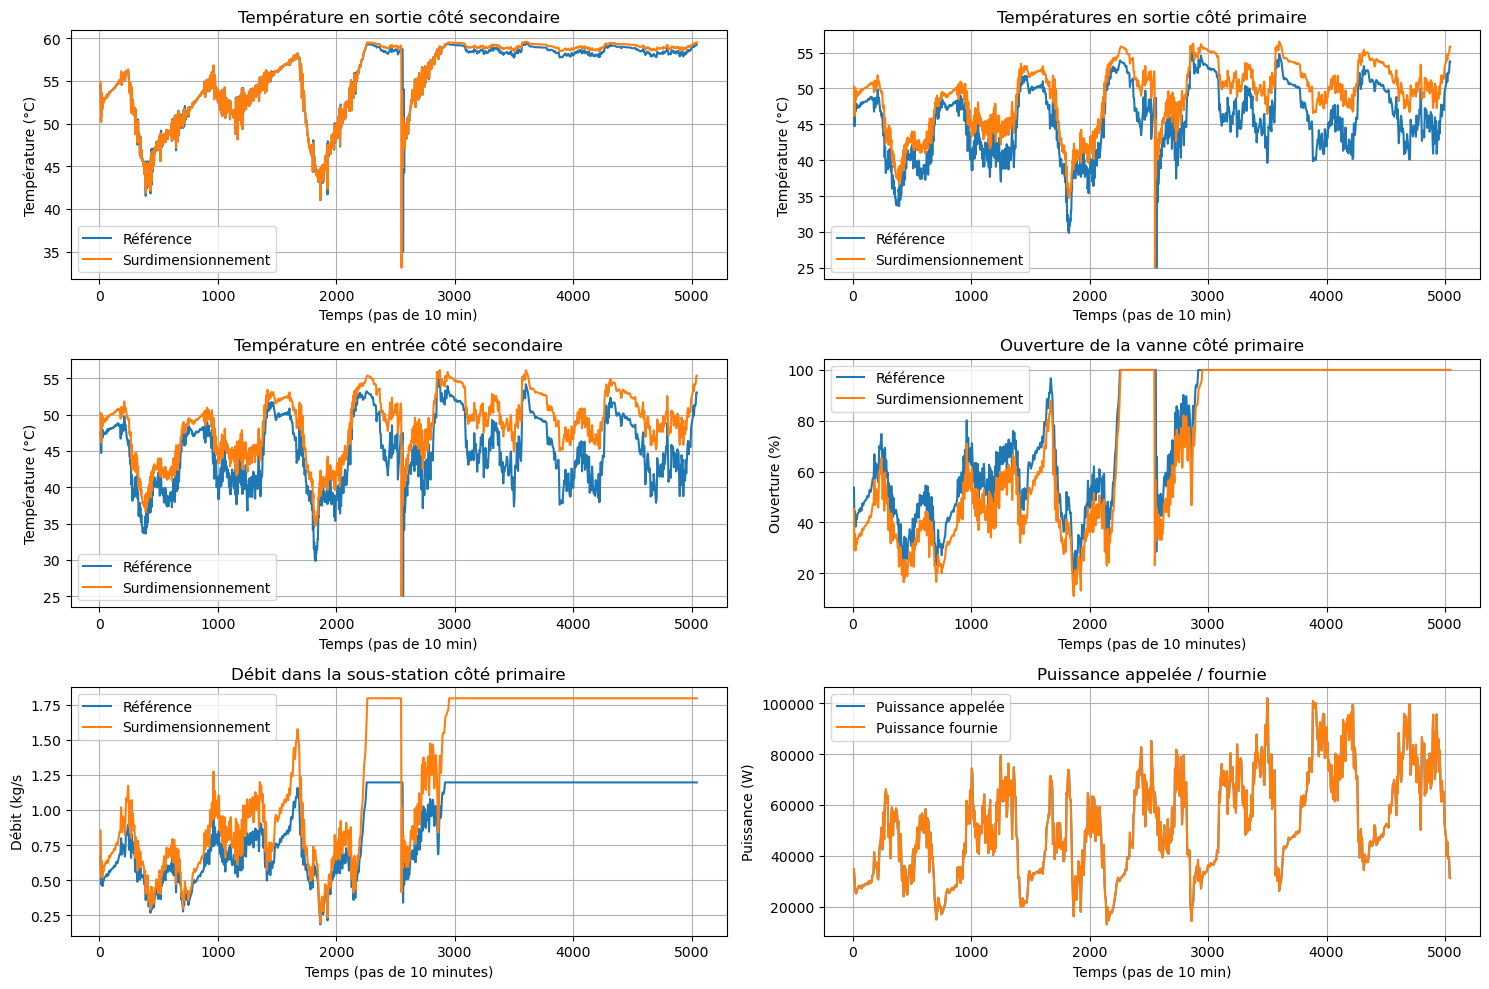

In [13]:
fig1, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,2], label = "Référence")
ax0.plot(np.arange(10,int(temps_simu/dt)),SST_surdim[10:,2], label = "Surdimensionnement")
ax0.set_title('Température en sortie côté secondaire')
ax0.legend()
ax0.grid()
ax0.set_xlabel('Temps (pas de 10 min)')
ax0.set_ylabel('Température (°C)')

ax1.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,3], label = "Référence")
ax1.plot(np.arange(10,int(temps_simu/dt)),SST_surdim[10:,3], label = "Surdimensionnement")
ax1.set_title('Températures en sortie côté primaire')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Temps (pas de 10 min)')
ax1.set_ylabel('Température (°C)')

ax2.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,5], label = "Référence")
ax2.plot(np.arange(10,int(temps_simu/dt)),SST_surdim[10:,5], label = "Surdimensionnement")
ax2.set_title('Température en entrée côté secondaire')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Temps (pas de 10 min)')
ax2.set_ylabel('Température (°C)')

ax3.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,8]*100,label = "Référence")
ax3.plot(np.arange(10,int(temps_simu/dt)),SST_surdim[10:,8]*100, label ="Surdimensionnement")
ax3.set_title('Ouverture de la vanne côté primaire')
ax3.set_xlabel('Temps (pas de 10 minutes)')
ax3.set_ylabel('Ouverture (%)')
ax3.legend()
ax3.grid()

ax4.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,4],label = "Référence")
ax4.plot(np.arange(10,int(temps_simu/dt)),SST_surdim[10:,4],label = "Surdimensionnement")
ax4.set_title('Débit dans la sous-station côté primaire')
ax4.set_xlabel('Temps (pas de 10 minutes)')
ax4.set_ylabel('Débit (kg/s')
ax4.legend()
ax4.grid()

ax5.plot(np.arange(10,int(temps_simu/dt)),P_SST_discret[10:], label = "Puissance appelée")
ax5.plot(np.arange(10,int(temps_simu/dt)),SST_surdim[10:,0], label = "Puissance fournie")
ax5.set_title('Puissance appelée / fournie')
ax5.legend()
ax5.grid()
ax5.set_xlabel('Temps (pas de 10 min)')
ax5.set_ylabel('Puissance (W)')

os.chdir(dossier+'\\Outputs')
fig1.savefig("surdimensionnement.png")
os.chdir(dossier)

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'
    

## Analyse du sous-dimensionnement


Pour simuler un sous-dimensionnement, on diminue la puissance nominale de la sous-station de 50% par rapport à la valeur de la sous-station de référence.

*<ins>Question 2</ins> : Modifier les données d'entrées en conséquence et exécuter le calcul. Observer les sorties du modèle et comparer avec la situation de référence*

In [14]:
#Caractéristiques nominales connues de la SST
P_nom = 50000
E_nom = 0.9
Ts_in_nom = 60
Ts_out_nom = 80

#Paramètres de la régulation
Kp = 0.005 #terme proportionnel
Ki = 0.05  #terme intégrateur
Kd = 0.0   #terme dérivateur
dt = 0.2 #échantillonnage temporel de la régulation (ie discrétisation temporelle de la simulation de la régulation)

#Détermination du point nominal
Carac_nom=RDC.SST_nom(Kp, Ki, Kd, Ts_out_nom, Ts_in_nom, E_nom, P_nom)

In [15]:
#Initialisation
SST_State = np.zeros((int(temps_simu/dt),9)) #Vecteur des sorties calculées (P_fournie, Tcons, Ts_out, Tp_out, Mp, Ts_in, EcartT, IntegraleEcartT, Youv)
SST_State[0,6] = 0 #Initialisation de l'écart à la consigne
SST_State[0,7] = 0 #Initialisation de la dérivée de l'écart
SST_State[0,8] = 0.5  #Initialisation de l'ouverture de la vanne

Tp_in_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Tp_in)
P_SST_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),P_SST)
Text_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Text)

#Boucle de calcul
for t in range(1,int(temps_simu/dt)):
    SST_State[t]=RDC.SST_fonct(Carac_nom, SST_State[t-1,8], Tp_in_discret[t], P_SST_discret[t], Text_discret[t], SST_State[t-1,6], SST_State[t-1,7], dt)
SST_sousdim=SST_State


**Sorties graphiques**

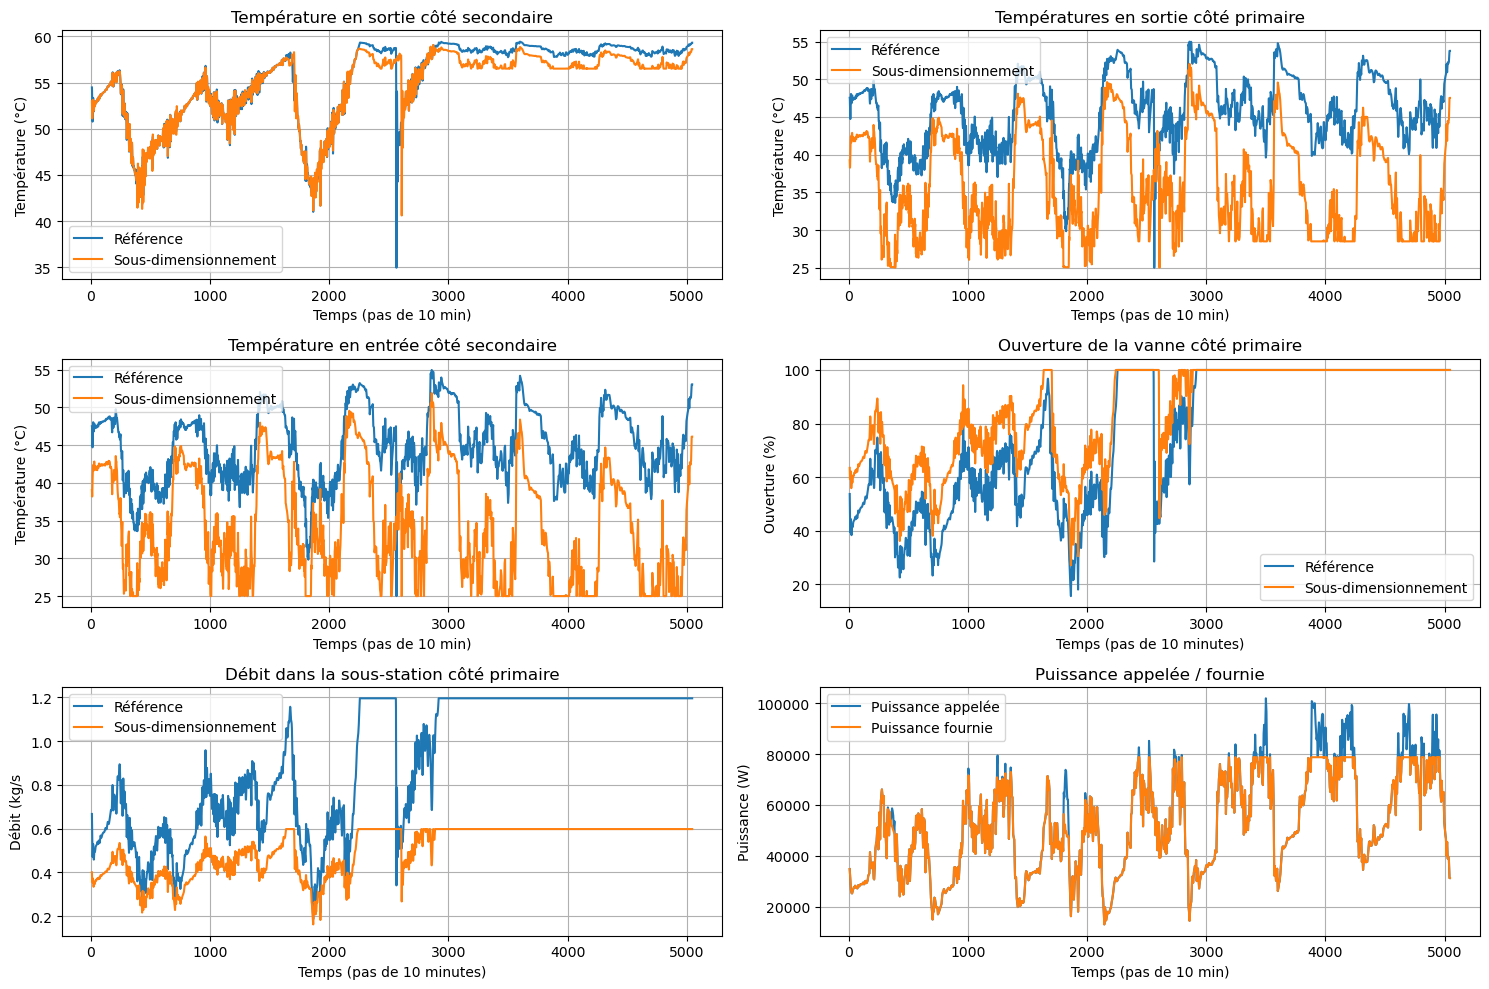

In [16]:
fig1, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,2], label = "Référence")
ax0.plot(np.arange(10,int(temps_simu/dt)),SST_sousdim[10:,2], label = "Sous-dimensionnement")
ax0.set_title('Température en sortie côté secondaire')
ax0.legend()
ax0.grid()
ax0.set_xlabel('Temps (pas de 10 min)')
ax0.set_ylabel('Température (°C)')

ax1.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,3], label = "Référence")
ax1.plot(np.arange(10,int(temps_simu/dt)),SST_sousdim[10:,3], label = "Sous-dimensionnement")
ax1.set_title('Températures en sortie côté primaire')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Temps (pas de 10 min)')
ax1.set_ylabel('Température (°C)')

ax2.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,5], label = "Référence")
ax2.plot(np.arange(10,int(temps_simu/dt)),SST_sousdim[10:,5], label = "Sous-dimensionnement")
ax2.set_title('Température en entrée côté secondaire')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Temps (pas de 10 min)')
ax2.set_ylabel('Température (°C)')

ax3.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,8]*100,label = "Référence")
ax3.plot(np.arange(10,int(temps_simu/dt)),SST_sousdim[10:,8]*100, label ="Sous-dimensionnement")
ax3.set_title('Ouverture de la vanne côté primaire')
ax3.set_xlabel('Temps (pas de 10 minutes)')
ax3.set_ylabel('Ouverture (%)')
ax3.legend()
ax3.grid()

ax4.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,4],label = "Référence")
ax4.plot(np.arange(10,int(temps_simu/dt)),SST_sousdim[10:,4],label = "Sous-dimensionnement")
ax4.set_title('Débit dans la sous-station côté primaire')
ax4.set_xlabel('Temps (pas de 10 minutes)')
ax4.set_ylabel('Débit (kg/s')
ax4.legend()
ax4.grid()

ax5.plot(np.arange(10,int(temps_simu/dt)),P_SST_discret[10:], label = "Puissance appelée")
ax5.plot(np.arange(10,int(temps_simu/dt)),SST_sousdim[10:,0], label = "Puissance fournie")
ax5.set_title('Puissance appelée / fournie')
ax5.legend()
ax5.grid()
ax5.set_xlabel('Temps (pas de 10 min)')
ax5.set_ylabel('Puissance (W)')

os.chdir(dossier+'\\Outputs')
fig1.savefig("sousdimensionnement.png")
os.chdir(dossier)

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'
    

## Analyse du changement de régime de température au secondaire

Le régime de température du réseau secondaire devient 60/40°C (au lieu de 80/60°C)

*<ins>Question 4</ins> : Modifier les données d'entrées en conséquence et exécuter le calcul. Observer les sorties du modèle et comparer avec la situation de référence*

In [17]:
#Caractéristiques nominales connues de la SST
P_nom = 100000
E_nom = 0.9
Ts_in_nom = 40
Ts_out_nom = 60

#Paramètres de la régulation
Kp = 0.005 #terme proportionnel
Ki = 0.05  #terme intégrateur
Kd = 0.0   #terme dérivateur
dt = 0.2 #échantillonnage temporel de la régulation (ie discrétisation temporelle de la simulation de la régulation)

#Détermination du point nominal
Carac_nom=RDC.SST_nom(Kp, Ki, Kd, Ts_out_nom, Ts_in_nom, E_nom, P_nom)

In [18]:
#Initialisation
SST_State = np.zeros((int(temps_simu/dt),9)) #Vecteur des sorties calculées (P_fournie, Tcons, Ts_out, Tp_out, Mp, Ts_in, EcartT, IntegraleEcartT, Youv)
SST_State[0,6] = 0 #Initialisation de l'écart à la consigne
SST_State[0,7] = 0 #Initialisation de la dérivée de l'écart
SST_State[0,8] = 0.5  #Initialisation de l'ouverture de la vanne

Tp_in_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Tp_in)
P_SST_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),P_SST)
Text_discret = np.interp((np.arange(0,temps_simu,dt)),np.linspace(0,temps_simu-1,temps_simu),Text)

#Boucle de calcul
for t in range(1,int(temps_simu/dt)):
    SST_State[t]=RDC.SST_fonct(Carac_nom, SST_State[t-1,8], Tp_in_discret[t], P_SST_discret[t], Text_discret[t], SST_State[t-1,6], SST_State[t-1,7], dt)
SST_6040=SST_State

**Sorties graphiques**

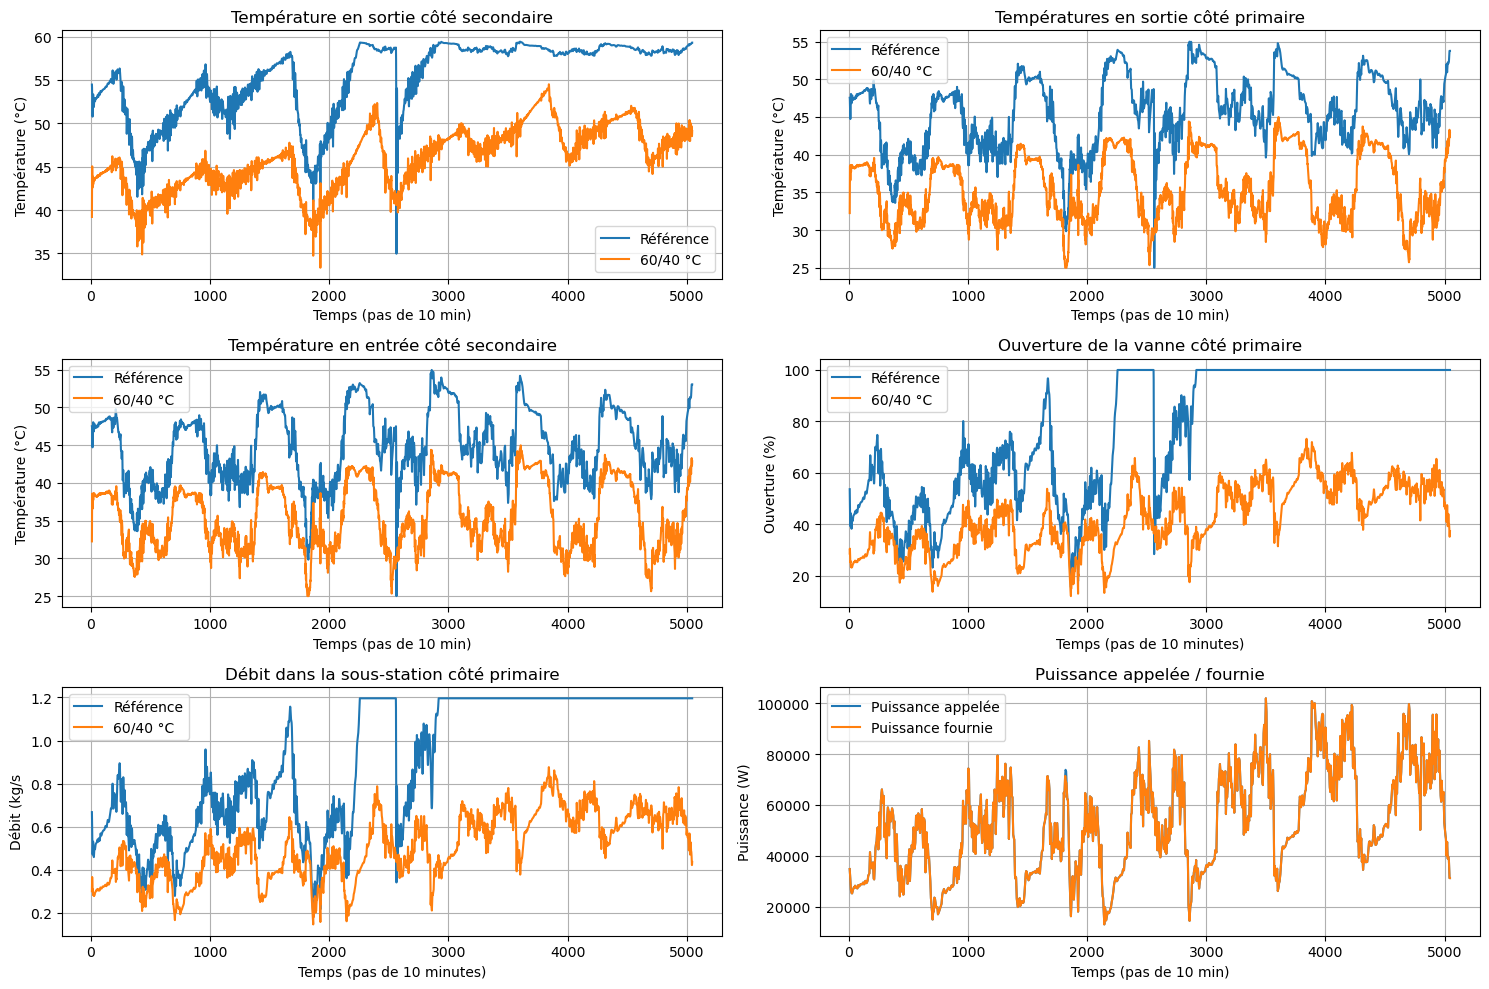

In [20]:
fig1, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,2], label = "Référence")
ax0.plot(np.arange(10,int(temps_simu/dt)),SST_6040[10:,2], label = "60/40 °C")
ax0.set_title('Température en sortie côté secondaire')
ax0.legend()
ax0.grid()
ax0.set_xlabel('Temps (pas de 10 min)')
ax0.set_ylabel('Température (°C)')

ax1.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,3], label = "Référence")
ax1.plot(np.arange(10,int(temps_simu/dt)),SST_6040[10:,3], label = "60/40 °C")
ax1.set_title('Températures en sortie côté primaire')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Temps (pas de 10 min)')
ax1.set_ylabel('Température (°C)')

ax2.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,5], label = "Référence")
ax2.plot(np.arange(10,int(temps_simu/dt)),SST_6040[10:,5], label = "60/40 °C")
ax2.set_title('Température en entrée côté secondaire')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Temps (pas de 10 min)')
ax2.set_ylabel('Température (°C)')

ax3.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,8]*100,label = "Référence")
ax3.plot(np.arange(10,int(temps_simu/dt)),SST_6040[10:,8]*100, label ="60/40 °C")
ax3.set_title('Ouverture de la vanne côté primaire')
ax3.set_xlabel('Temps (pas de 10 minutes)')
ax3.set_ylabel('Ouverture (%)')
ax3.legend()
ax3.grid()

ax4.plot(np.arange(10,int(temps_simu/dt)),SST_reference[10:,4],label = "Référence")
ax4.plot(np.arange(10,int(temps_simu/dt)),SST_6040[10:,4],label = "60/40 °C")
ax4.set_title('Débit dans la sous-station côté primaire')
ax4.set_xlabel('Temps (pas de 10 minutes)')
ax4.set_ylabel('Débit (kg/s')
ax4.legend()
ax4.grid()

ax5.plot(np.arange(10,int(temps_simu/dt)),P_SST_discret[10:], label = "Puissance appelée")
ax5.plot(np.arange(10,int(temps_simu/dt)),SST_6040[10:,0], label = "Puissance fournie")
ax5.set_title('Puissance appelée / fournie')
ax5.legend()
ax5.grid()
ax5.set_xlabel('Temps (pas de 10 min)')
ax5.set_ylabel('Puissance (W)')

os.chdir(dossier+'\\Outputs')
fig1.savefig("Regime 60_40.png")
os.chdir(dossier)

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'
    

## Analyse de la baisse d'efficacité

L'efficacité de l'échangeur peut diminuer au cours de son exploitation, en raison d'un encrassement par exemple. On simule ici la dégradation de cette efficacité de 0,9 à 0,7.

*<ins>Question 5</ins> : Modifier les données d'entrées en conséquence et exécuter le calcul. Observer les sorties du modèle et comparer avec la situation de référence*

In [21]:
#Caractéristiques nominales connues de la SST
P_nom = 120000
E_nom = 0.7
Ts_in_nom = 60
Ts_out_nom = 80

#Paramètres de la régulation
Kp = 0.004 #terme proportionnel 
Ki = 0.01  #terme intégrateur
Kd = 0.0   #terme dérivateur
dt = 0.2 #échantillonnage temporel de la régulation (ie discrétisation temporelle de la simulation de la régulation)

#Détermination du point nominal
Carac_nom=RDC.SST_nom(Kp, Ki, Kd, Ts_out_nom, Ts_in_nom, E_nom, P_nom)

In [22]:
#Initialisation
Tp_in = 65*np.ones(int(temps_simu/dt))
Text = np.array(Input['Text']) # Vecteur des températures extérieures
P_SST = np.array(Input['P (W)']) # Vecteur des puissances appelées côté secondaire
SST_State = np.zeros((int(temps_simu/dt),9)) #Vecteur des sorties calculées (P_fournie, Tcons, Ts_out, Tp_out, Mp, Ts_in, inconfort, Youv)
SST_State[0,8] = 0.5  #Initialisation de l'ouverture de la vanne

#Boucle de calcul
for t in range(1,int(temps_simu/dt)):
    SST_State[t]=RDC.SST_fonct(Carac_nom, SST_State[t-1,8], Tp_in_discret[t], P_SST_discret[t], Text_discret[t], SST_State[t-1,6], SST_State[t-1,7], dt)
SST_baisseEff=SST_State


**Sorties graphiques**

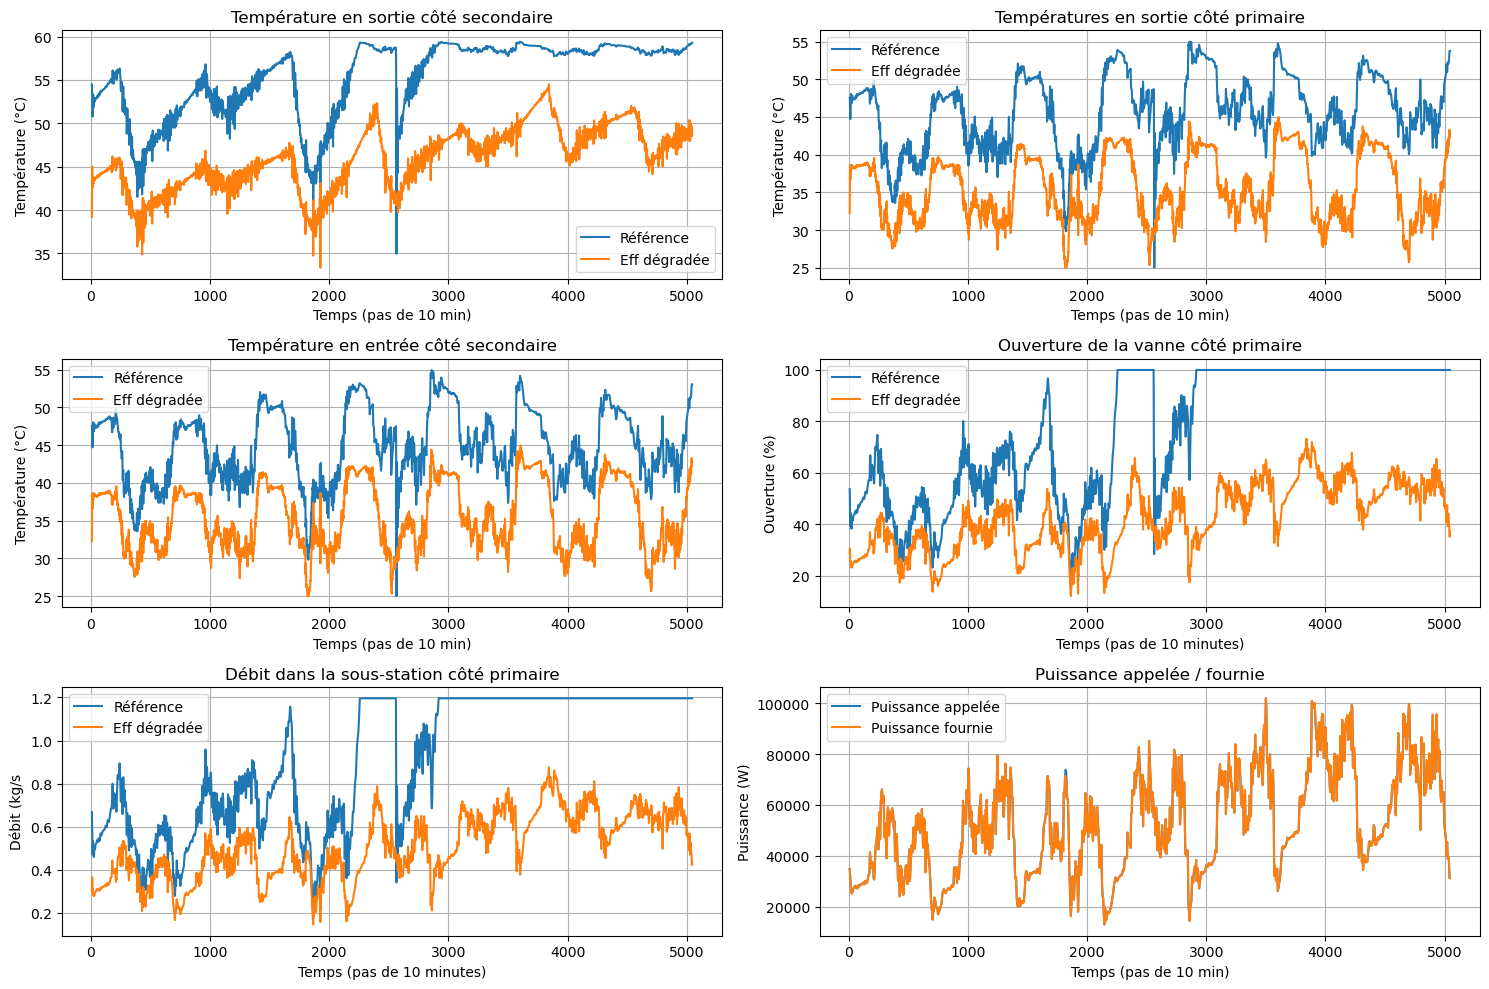

In [23]:
fig1, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
ax_t = np.arange(10,int(temps_simu/dt))

ax0.plot(ax_t,SST_reference[10:,2], label = "Référence")
ax0.plot(ax_t,SST_6040[10:,2], label = "Eff dégradée")
ax0.set_title('Température en sortie côté secondaire')
ax0.legend()
ax0.grid()
ax0.set_xlabel('Temps (pas de 10 min)')
ax0.set_ylabel('Température (°C)')

ax1.plot(ax_t,SST_reference[10:,3], label = "Référence")
ax1.plot(ax_t,SST_6040[10:,3], label = "Eff dégradée")
ax1.set_title('Températures en sortie côté primaire')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Temps (pas de 10 min)')
ax1.set_ylabel('Température (°C)')

ax2.plot(ax_t,SST_reference[10:,5], label = "Référence")
ax2.plot(ax_t,SST_6040[10:,5], label = "Eff dégradée")
ax2.set_title('Température en entrée côté secondaire')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Temps (pas de 10 min)')
ax2.set_ylabel('Température (°C)')

ax3.plot(ax_t,SST_reference[10:,8]*100,label = "Référence")
ax3.plot(ax_t,SST_6040[10:,8]*100, label ="Eff degradée")
ax3.set_title('Ouverture de la vanne côté primaire')
ax3.set_xlabel('Temps (pas de 10 minutes)')
ax3.set_ylabel('Ouverture (%)')
ax3.legend()
ax3.grid()

ax4.plot(ax_t,SST_reference[10:,4],label = "Référence")
ax4.plot(ax_t,SST_6040[10:,4],label = "Eff dégradée")
ax4.set_title('Débit dans la sous-station côté primaire')
ax4.set_xlabel('Temps (pas de 10 minutes)')
ax4.set_ylabel('Débit (kg/s')
ax4.legend()
ax4.grid()

ax5.plot(ax_t,P_SST_discret[10:], label = "Puissance appelée")
ax5.plot(ax_t,SST_6040[10:,0], label = "Puissance fournie")
ax5.set_title('Puissance appelée / fournie')
ax5.legend()
ax5.grid()
ax5.set_xlabel('Temps (pas de 10 min)')
ax5.set_ylabel('Puissance (W)')

os.chdir(dossier+'\\Outputs')
fig1.savefig("Baisse efficacité.png")
os.chdir(dossier)

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'